# EDA on Merged Dataset (Forward Filled!)

In [59]:
import pandas as pd
import numpy as np

## 1. Fixing Datatypes

In [82]:
# Print the datatypes of all columns

merged_df = pd.read_csv('../data/processed/merged_dataset_ffill.csv', sep = ';')

print(merged_df.dtypes)
print(merged_df.isnull().sum())

/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_5970/1567368633.py:3: DtypeWarning: Columns (3,5,8,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('../data/processed/merged_dataset_ffill.csv', sep = ';')


utc_timestamp                            object
cet_cest_timestamp                       object
DE_load_actual_entsoe_transparency      float64
DE_load_forecast_entsoe_transparency     object
DE_solar_capacity                         int64
DE_solar_generation_actual               object
DE_solar_profile                        float64
DE_wind_capacity                          int64
DE_wind_generation_actual                object
DE_wind_profile                         float64
DE_wind_offshore_capacity                 int64
DE_wind_offshore_generation_actual       object
DE_wind_offshore_profile                float64
DE_wind_onshore_capacity                  int64
DE_wind_onshore_generation_actual        object
DE_wind_onshore_profile                 float64
DE_temperature                          float64
DE_radiation_direct_horizontal           object
DE_radiation_diffuse_horizontal          object
hour                                    float64
dtype: object
utc_timestamp             

In [83]:
# Convert timestamp columns to datetime
merged_df['utc_timestamp'] = pd.to_datetime(merged_df['utc_timestamp'], utc =True)

# Delete CET timestamp colum
#merged_df_ffill.drop(columns=["cet_cest_timestamp"], inplace=True) (Done)

print(merged_df.columns)
print(merged_df.isnull().sum())

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'hour'],
      dtype='object')
utc_timestamp                             0
cet_cest_timestamp                        0
DE_load_actual_entsoe_transparency        0
DE_load_forecast_entsoe_transparency     96
DE_solar_capacity                         0
DE_solar_generation_actual              384
DE_solar_profile                        384
DE_wind_capacity                          0
DE_wind_generatio

In [84]:
columns_to_convert = [
    "DE_load_actual_entsoe_transparency",
    "DE_load_forecast_entsoe_transparency",
    "DE_solar_generation_actual",
    "DE_wind_generation_actual",
    "DE_wind_offshore_generation_actual",
    "DE_wind_onshore_generation_actual"
]

for col in columns_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

print(merged_df.isnull().sum())

utc_timestamp                             0
cet_cest_timestamp                        0
DE_load_actual_entsoe_transparency        0
DE_load_forecast_entsoe_transparency    102
DE_solar_capacity                         0
DE_solar_generation_actual              481
DE_solar_profile                        384
DE_wind_capacity                          0
DE_wind_generation_actual               399
DE_wind_profile                         298
DE_wind_offshore_capacity                 0
DE_wind_offshore_generation_actual      335
DE_wind_offshore_profile                298
DE_wind_onshore_capacity                  0
DE_wind_onshore_generation_actual       380
DE_wind_onshore_profile                 288
DE_temperature                            0
DE_radiation_direct_horizontal            0
DE_radiation_diffuse_horizontal           0
hour                                      0
dtype: int64


In [85]:
# Identify rows where target is missing
missing_target_rows = merged_df[merged_df["DE_load_actual_entsoe_transparency"].isna()]

# Print indexes and timestamps
print(missing_target_rows[["utc_timestamp"]])


Empty DataFrame
Columns: [utc_timestamp]
Index: []


In [86]:
# print the min and max of the DE_load_actual_entsoe_transparency column
print("Minimum value of DE_load_actual_entsoe_transparency:", merged_df["DE_load_actual_entsoe_transparency"].min())
# index of the min value
min_index = merged_df["DE_load_actual_entsoe_transparency"].idxmin()
print("Index of minimum value:", min_index)
# timestamp of the min value
print("Timestamp of minimum value:", merged_df.loc[min_index, "utc_timestamp"])

print("Maximum value of DE_load_actual_entsoe_transparency:", merged_df["DE_load_actual_entsoe_transparency"].max())

Minimum value of DE_load_actual_entsoe_transparency: 29158.12
Index of minimum value: 148774
Timestamp of minimum value: 2019-03-31 00:45:00+00:00
Maximum value of DE_load_actual_entsoe_transparency: 77852.94


## 2. Missing Values

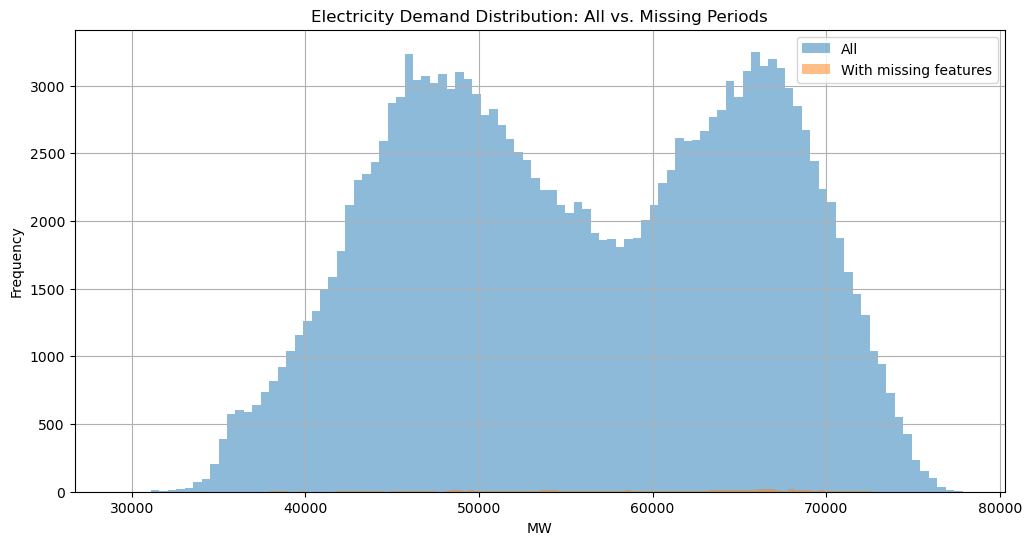

In [88]:
# Analyze Target Variable Behavior During Missing Periods

# Identify rows with any missing value
missing_any = merged_df[merged_df.isna().any(axis=1)]

# Compare distribution of the target during missing vs non-missing periods
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
merged_df["DE_load_actual_entsoe_transparency"].hist(alpha=0.5, label="All", bins=100)
missing_any["DE_load_actual_entsoe_transparency"].hist(alpha=0.5, label="With missing features", bins=100)
plt.title("Electricity Demand Distribution: All vs. Missing Periods")
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Confirms that missing data periods occur fairly uniformly across the full range of demand, with no strong bias toward low or high consumption. That means you’re unlikely to introduce major distortions when imputing missing values for features, as your target distribution remains stable.

In [89]:
# Create is_daylight column

merged_df["is_daylight"] = merged_df["hour"].between(6, 20).astype(int)

Some analysis on imputation strategy:

Cannot just drop columns - due to time-series structure, temporal continuity and regular time steps matter. Preserving the time index matters for lags and training.

Ffill is a safe but not very intelligent method - it will flatten the curve of cyclical daily patterns.

(group-wise) interpolation could be a smarter technique.

Model-based imputation is possible with TFTs. Overkill for now, but keep a version of the merged dataset WITH missing values, which might be useful later.

In [91]:
# Save a backup before imputation
merged_df.to_csv("../data/processed/merged_dataset_pre_imputation.csv", index=False)


/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_5970/710879647.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


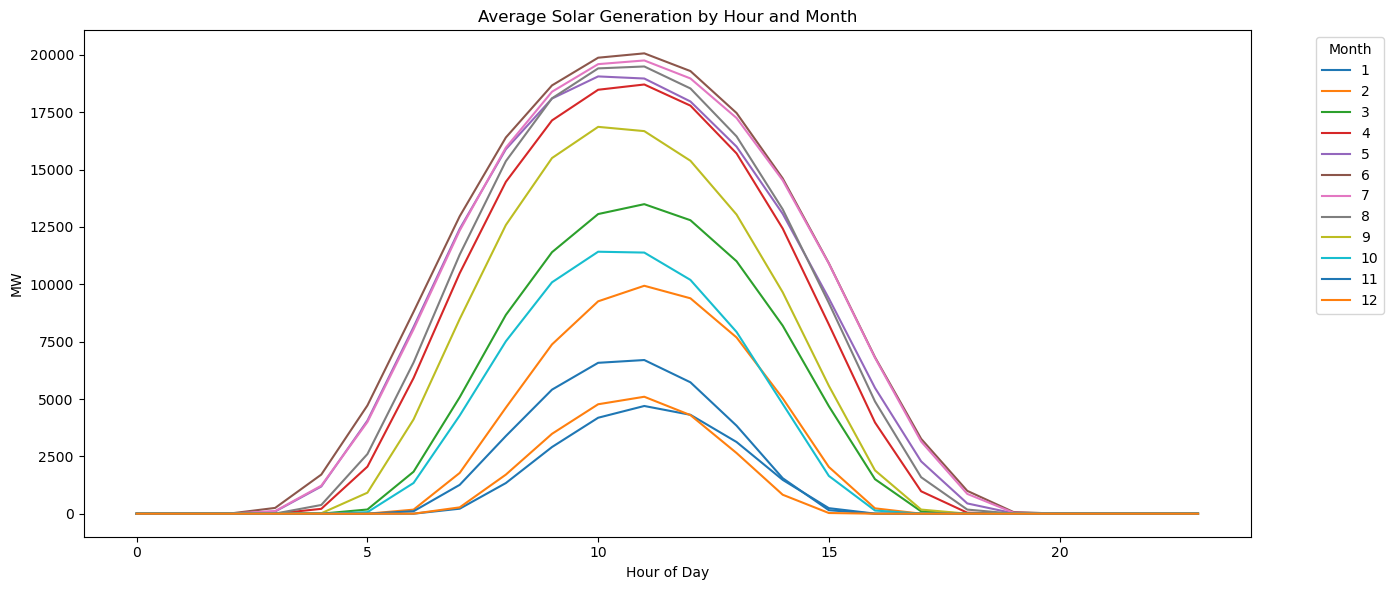

In [93]:
# Create a 'month' column (you already have 'hour')
merged_df["month"] = merged_df["utc_timestamp"].dt.month

# Check monthly hourly patterns for solar generation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=merged_df,
    x="hour",
    y="DE_solar_generation_actual",
    hue="month",
    palette="tab10",
    estimator="mean",
    ci=None
)
plt.title("Average Solar Generation by Hour and Month")
plt.ylabel("MW")
plt.xlabel("Hour of Day")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Helps confirm the seasonal + daily solar pattern, which we’ll use for imputation.

In [97]:
# Build average solar generation values by hour and month
solar_pattern = merged_df.groupby(["month", "hour"])["DE_solar_generation_actual"].mean()

# Define a function to fill missing solar generation values using the pattern
def fill_with_solar_pattern(row):
    if pd.isna(row["DE_solar_generation_actual"]):
        return solar_pattern.loc[(row["month"], row["hour"])]
    else:
        return row["DE_solar_generation_actual"]

# Apply to the solar generation column
merged_df["DE_solar_generation_actual"] = merged_df.apply(fill_with_solar_pattern, axis=1)


In [98]:
# Select other generation columns that benefit from smoother gaps being filled
generation_cols_interpolate = [
    "DE_wind_generation_actual",
    "DE_wind_offshore_generation_actual",
    "DE_wind_onshore_generation_actual"
]

# Time interpolation (assumes utc_timestamp is datetime and sorted)
merged_df.set_index("utc_timestamp", inplace=True)
merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].interpolate(method='time')

# Reset index for further operations
merged_df.reset_index(inplace=True)


In [99]:
# Fallback in case any NaNs remain at beginning or end of time series
merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].fillna(method="ffill").fillna(method="bfill")


/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_5970/143081604.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].fillna(method="ffill").fillna(method="bfill")


✔ Saved original dataset for model-based or radiation-aware imputation later
✔ Used pattern-based interpolation (hour + month) for solar — respects seasonality & daily cycles
✔ Used time-based interpolation for wind — smooth enough, often less sharply cyclical
✔ Used forward/backward fill for edge NaNs — avoids gaps for time-series models
✔ Deferred advanced methods (radiation-scaling, XGBoost/TFT imputers) to feature engineering stage

In [101]:
# Summarize missing values per column
missing_summary = merged_df.isna().sum()
print(missing_summary[missing_summary > 0])


DE_load_forecast_entsoe_transparency    102
DE_solar_profile                        384
DE_wind_profile                         298
DE_wind_offshore_profile                298
DE_wind_onshore_profile                 288
dtype: int64


In [102]:
# Check for duplicate or missing times
print(merged_df["utc_timestamp"].diff().value_counts())


utc_timestamp
0 days 00:15:00    175166
Name: count, dtype: int64
